<a href="https://colab.research.google.com/github/JeevaGowtham-S/Transfer-Learning-for-binary-classification/blob/main/dlexp3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from os import getcwd

In [2]:
path_inception = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


from tensorflow.keras.applications.inception_v3 import InceptionV3

#### Create an instance of the inception model from the local pre-trained weights

local_weights_file = path_inception

pre_trained_model = InceptionV3(include_top = False,
                                input_shape = (150, 150, 3),
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

In [3]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [4]:
pre_trained_model.summary()
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

last layer output shape:  (None, 7, 7, 768)


In [5]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs['accuracy']>0.97:
            self.model.stop_training = True
            print("\nReached 97.0% accuracy so cancelling training!")

In [6]:
from tensorflow.keras.optimizers import RMSprop
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = Model(pre_trained_model.input, outputs = x)

In [7]:
model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.00001),
        loss='binary_crossentropy', # use a loss for binary classification
        metrics=['accuracy']
    )


In [8]:
print('Name: JEEVAGOWTHAM S      Register Number: 212222230053')
model.summary()

Name: JEEVAGOWTHAM S      Register Number: 212222230053


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 47,512,481 (181.25 MB)

 Trainable params: 38,537,217 (147.01 MB)

 Non-trainable params: 8,975,264 (34.24 MB)

In [9]:
# Get the Horse or Human dataset
path_horse_or_human = '/content/horse-or-human.zip'
# Get the Horse or Human Validation dataset
path_validation_horse_or_human = '/content/validation-horse-or-human.zip'
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = path_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = path_validation_horse_or_human
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation')
zip_ref.close()


In [10]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))



500
527
128
128


In [11]:

train_datagen = ImageDataGenerator(rescale = 1/255,
                                  height_shift_range = 0.2,
                                  width_shift_range = 0.2,
                                  horizontal_flip = True,
                                  vertical_flip = True,
                                  rotation_range = 0.4,
                                  shear_range = 0.1,
                                  zoom_range = 0.3,
                                  fill_mode = 'nearest'
                                  )
# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1/255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   target_size = (150, 150),
                                                   batch_size = 20,
                                                   class_mode = 'binary',
                                                   shuffle = True)

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                        target_size = (150, 150),
                                                        batch_size =20,
                                                        class_mode = 'binary',
                                                        shuffle = False)


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [12]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    seed=7
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=validation_dir,
    batch_size=32,
    image_size=(150, 150),
    shuffle=True,
    seed=7
)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [13]:
callbacks = myCallback()
history = model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 10,
    verbose = 2,
    callbacks = [myCallback()],
)

Epoch 1/10
33/33 - 99s - 3s/step - accuracy: 0.6962 - loss: 6.5754 - val_accuracy: 0.7422 - val_loss: 5.5043
Epoch 2/10
33/33 - 99s - 3s/step - accuracy: 0.8335 - loss: 2.8079 - val_accuracy: 0.7539 - val_loss: 10.2341
Epoch 3/10
33/33 - 137s - 4s/step - accuracy: 0.8578 - loss: 2.5963 - val_accuracy: 0.9141 - val_loss: 3.5599
Epoch 4/10
33/33 - 95s - 3s/step - accuracy: 0.9075 - loss: 1.2841 - val_accuracy: 0.8086 - val_loss: 9.0929
Epoch 5/10
33/33 - 140s - 4s/step - accuracy: 0.9367 - loss: 0.7968 - val_accuracy: 0.9258 - val_loss: 1.3583
Epoch 6/10
33/33 - 100s - 3s/step - accuracy: 0.9221 - loss: 0.9612 - val_accuracy: 0.9336 - val_loss: 2.7290
Epoch 7/10
33/33 - 151s - 5s/step - accuracy: 0.9416 - loss: 0.7335 - val_accuracy: 0.9219 - val_loss: 3.4879
Epoch 8/10
33/33 - 97s - 3s/step - accuracy: 0.9562 - loss: 0.6509 - val_accuracy: 0.8242 - val_loss: 9.8962
Epoch 9/10
33/33 - 141s - 4s/step - accuracy: 0.9435 - loss: 0.6630 - val_accuracy: 0.9180 - val_loss: 4.0113
Epoch 10/10
3

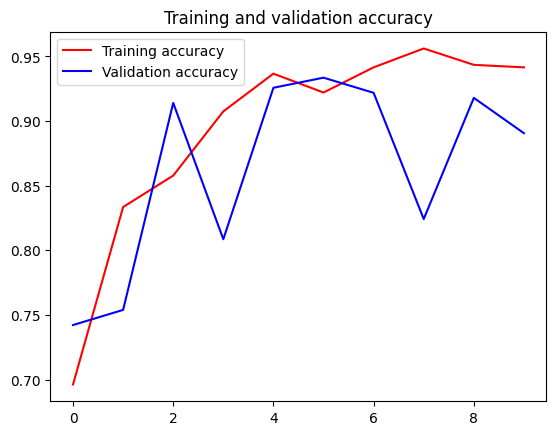

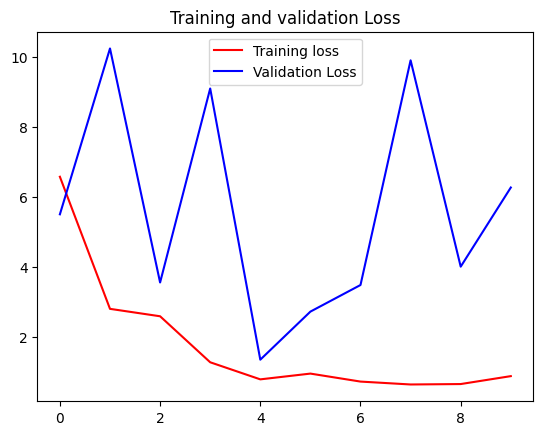

<Figure size 640x480 with 0 Axes>

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Name: JEEVAGOWTHAM S      Register Number: 212222230053')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()